# Automating Detection of Cancer Tissue

From genetic therapy to detection of various diseases, AI has revolutionized medical research. Recently, health researchers have innovatively applied AI to one of the most pressing health concerns of the century: cancer. Breast cancer is the second most common cancer in women. This project trains an AI model to detect cancer tissue in microscopic images. Early detection of metastatic tissue could potentially support health providers in developing swift diagnosis for patients, possibly saving their lives.

The data is provided in the [Patch Camelyon Challenge](https://patchcamelyon.grand-challenge.org/Introduction/). 

Note: the last model that has the highest accuracy can be found at the end of this notebook, but also separately on my [github](https://github.com/rominacarabathampi/Capstone-brainstation/blob/master/pcam%20code.ipynb)
_References_: 
- B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". [arXiv:1806.03962](https://arxiv.org/abs/1806.03962)
- Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. [doi:jama.2017.14585](https://jamanetwork.com/journals/jama/fullarticle/2665774)

# Exploratory Data Analysis

Download the files from [here](https://patchcamelyon.grand-challenge.org/Download/) and unzip. Save them in the same folder as the python code, but in a folder called "data".

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from keras.utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator
import time
import h5py
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


Read the training data for `x` and `y`. We will name the files `X_train` and `y_train` respectively.

In [2]:
# read X_train and y_train
X_train = HDF5Matrix('camelyonpatch_level_2_split_train_x.h5', 'x')
y_train = HDF5Matrix('camelyonpatch_level_2_split_train_y.h5', 'y')

In [3]:
#see the shape of the training files
print('The training data, x ',X_train.shape,' and y', y_train.shape)

The training data, x  (262144, 96, 96, 3)  and y (262144, 1, 1, 1)


We see that we have 262144 pictures. Each row of the column contains an image of 96x96 pixels. The last column indicates the channels of colors the picture contain. Let's check what type of variable those two are. 

In [4]:
# Check the type for X_train
type(X_train)

keras.utils.io_utils.HDF5Matrix

Read the test files. Same as above.

In [5]:
#read x_test and y_test
X_test = HDF5Matrix('camelyonpatch_level_2_split_test_x.h5', 'x')

y_test = HDF5Matrix('camelyonpatch_level_2_split_test_y.h5', 'y')

In [6]:
#see shape for the of them 
print('The test data, x ',X_test.shape,' and y', y_test.shape)

The test data, x  (32768, 96, 96, 3)  and y (32768, 1, 1, 1)


Read the validation files.

In [7]:
X_val = HDF5Matrix('camelyonpatch_level_2_split_valid_x.h5', 'x')
y_val = HDF5Matrix('camelyonpatch_level_2_split_valid_y.h5', 'y')

To understand the files better, let's import CSV files (the "meta" files).

In [8]:
#import the csv and see the shape
train_df = pd.read_csv("camelyonpatch_level_2_split_train_meta.csv")
train_df.shape

(262144, 6)

In [9]:
#import the csv and see the shape
test_df = pd.read_csv("camelyonpatch_level_2_split_test_meta.csv")
test_df.shape

(32768, 6)

In [10]:
#import the csv and see the shape
val_df = pd.read_csv("camelyonpatch_level_2_split_valid_meta.csv")
val_df.shape

(32768, 6)

So there are 262144 rows in the train data, and 32768 in the test and valid (both have equal number). Let's see how the data looks like

In [11]:
train_df.head()

,Unnamed: 0,coord_y,coord_x,tumor_patch,center_tumor_patch,wsi
0,0,63104,43648,False,False,camelyon16_train_tumor_104
1,1,148544,74048,True,True,camelyon16_train_tumor_003
2,2,64192,78912,True,True,camelyon16_train_tumor_089
3,3,98048,72128,True,True,camelyon16_train_tumor_004
4,4,27264,50688,False,False,camelyon16_train_normal_118


How many patients are we looking at? Supposedly each patient has more than one tumor. This means that the WSI (whole-slide images) should containt the patient identification number. Let's check how many patients are there.

In [12]:
#the number of unique patients
len(train_df['wsi'].unique())

216

So our theory is confirmed. There are 216 patients and each provided more than one lymph node to be studied. But let's see what the columns `tumor_patch` and `center_tumor_patch` are and how they differ.

In [13]:
# see the count of tumor patches
train_df['tumor_patch'].value_counts()

True     131745
False    130399
Name: tumor_patch, dtype: int64

In [14]:
# see the count of center tumor patches
train_df['center_tumor_patch'].value_counts()

True     131072
False    131072
Name: center_tumor_patch, dtype: int64

In our case, we will analyze the whole image, not just the center of it.

### Visualization of the cells

Let's visualize the first 25 pictures from the dataset that do contain cancerous tissue.

In [15]:
# Find locations of non tumors in the train dataframe
# Create an empty list to store the non_tumors
tumors = []

tumors = train_df[train_df['tumor_patch']==True].index
# Cut the list so we only see the first 25 of them
tumors = tumors[0:25]
#len(non_tumors)

In [16]:
tumors

Int64Index([ 1,  2,  3,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21,
            22, 24, 25, 26, 28, 29, 30, 31],
           dtype='int64')

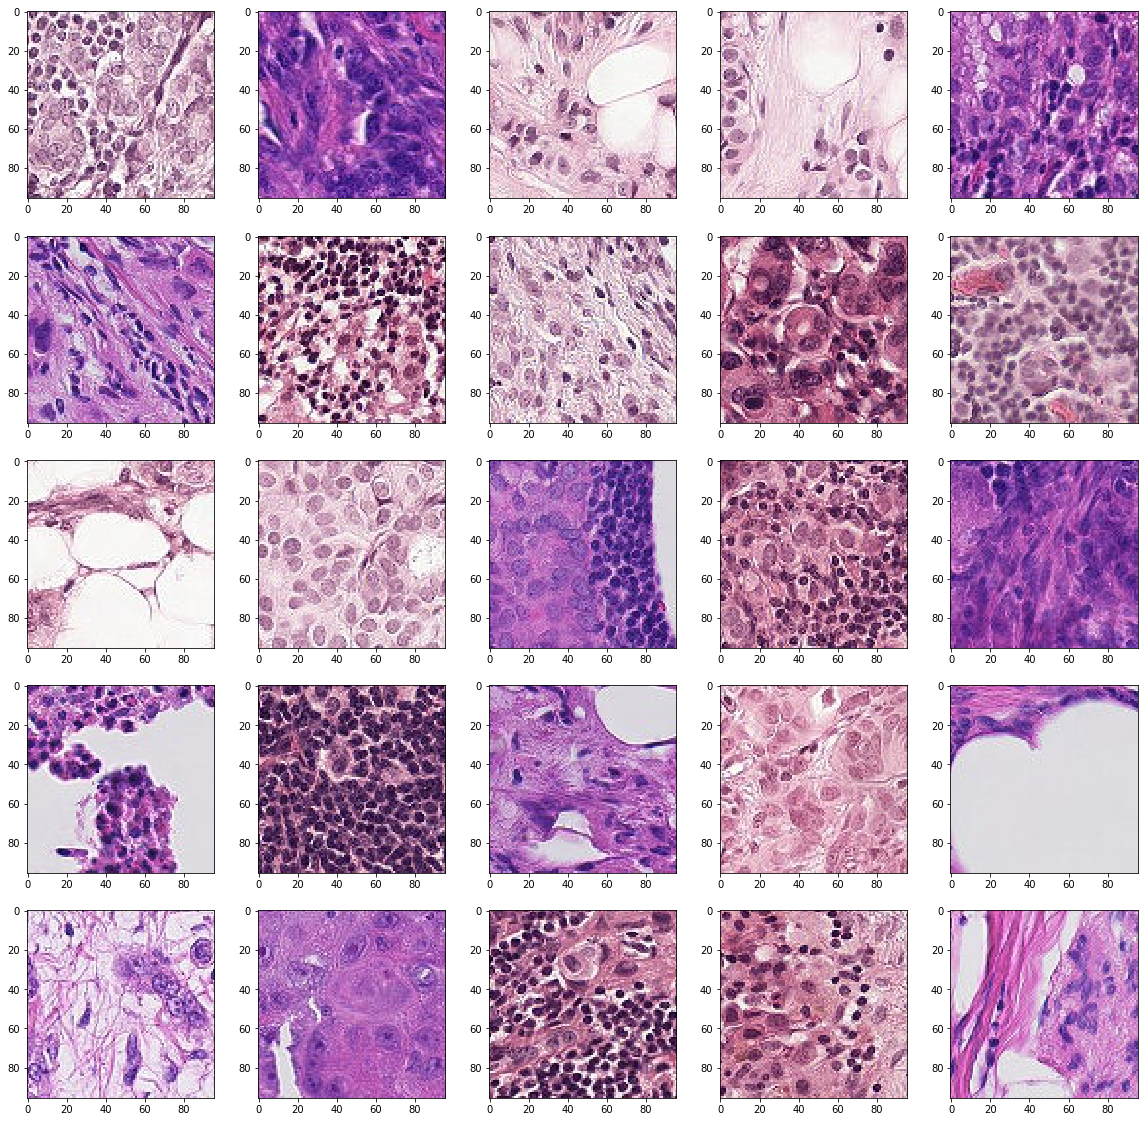

In [17]:
# Set the figure size to be 10 by 10
plt.subplots(5,5,figsize=(20,20))
# set a number to iterate through and plot at those locations in the subplot figure
num = 1
for i in tumors:
    #plt.figure(20,20)
    plt.subplot(5,5,num)
    num +=1 #increase the number -- to plot them in thier right position.
    plt.imshow(X_train[i][:,:,:])
plt.show()

Let's visualize the first 25 pictures from the dataset that do not contain cancerous tissue.

In [18]:
#retrieve the index of the columns where the Cancer is set to True
train_df[train_df['tumor_patch']==False].index

Int64Index([     0,      4,      5,      6,     13,     23,     27,     32,
                34,     39,
            ...
            262082, 262084, 262091, 262094, 262097, 262104, 262120, 262131,
            262137, 262142],
           dtype='int64', length=130399)

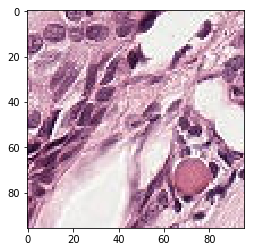

In [19]:
plt.imshow(X_train[1981][:,:,:])

In [20]:
# Find locations of non tumors in the train dataframe
# Create an empty list to store the non_tumors
non_tumors = []

non_tumors = train_df[train_df['tumor_patch']==False].index
# Cut the list so we only see the first 15 of them
non_tumors = non_tumors[0:25]
#len(non_tumors)

In [21]:
non_tumors

Int64Index([ 0,  4,  5,  6, 13, 23, 27, 32, 34, 39, 41, 48, 49, 50, 55, 57, 62,
            65, 71, 75, 79, 81, 82, 84, 85],
           dtype='int64')

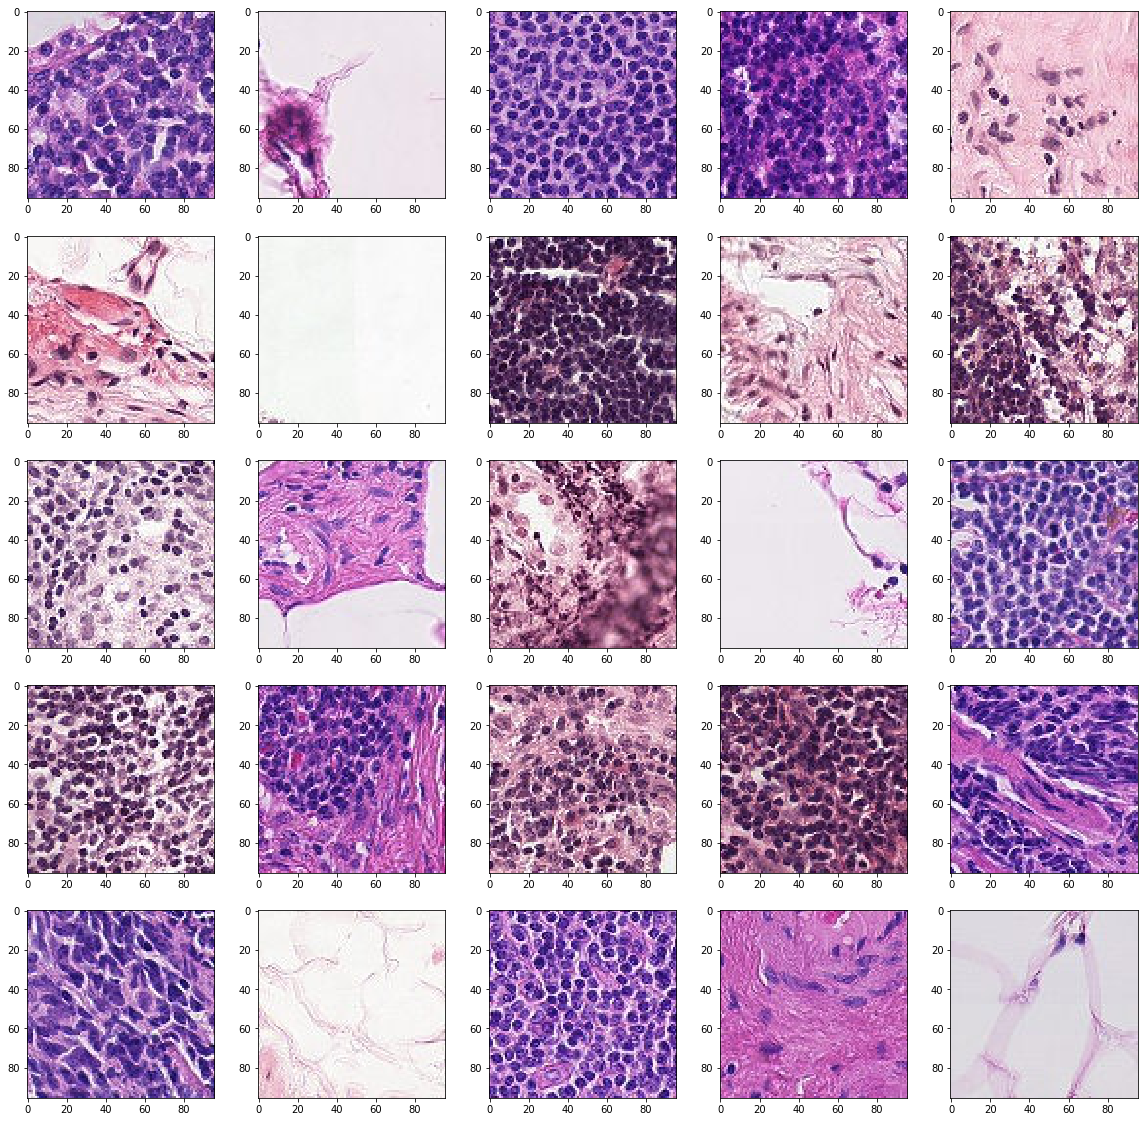

In [22]:
# Set the figure size to be 10 by 10
plt.subplots(5,5,figsize=(20,20))
# set a number to iterate through and plot at those locations in the subplot figure
num = 1
for i in non_tumors:
    #plt.figure(20,20)
    plt.subplot(5,5,num)
    num +=1
    plt.imshow(X_train[i][:,:,:])

plt.show()

## Build  a Convolutional Neural Network.

A few models will be presented and explanations will be provided on how they were created.

The goal is to build a model that has about 80% accuracy and be able to predict whether there is metastatic tissue in the images. 
What will we consider a good model? Anything that has an accuracy of >80%. The reason is this: in image classification the model can be trained to distinguish a certain shape (of a cat, of a house, or of a horse). But in this case, cancer does not have a particular shape, and thus achieving 100% accuracy will be nearly impossible. Maybe in the future this will be easy-peasy, but with the current development, it is not doable.

## 1. Build own CNN
#### Separate a small set from the training data (1050 instead of 260,000)
This is to build the model and have it work perfectly, then be able to run it on all data. It will save computational time and is good practice to make sure all goes well before we jump into running all the dataset.

1. Store the first 1050 arrays from `X_train` and `y_train` and build a model on them.

In [23]:
X_train.shape

(262144, 96, 96, 3)

In [24]:
#select a small chunk of train data
small_X_train = X_train[0:1050]
small_y_train = y_train[0:1050]
small_X_train.shape

(1050, 96, 96, 3)

2. Store the first 50 arrays from `X_test` and `y_test` and test the model on them.

In [25]:
X_val.shape

(32768, 96, 96, 3)

In [26]:
#select a small chunk of test data
small_X_test = X_test[0:500]
small_y_test = y_test[0:500]
small_X_test.shape

(500, 96, 96, 3)

In [27]:
#select a small chunk of validation data as well
small_X_val = X_val[0:500]
small_y_val = y_val[0:500]
small_X_val.shape

(500, 96, 96, 3)

3. Build the model on the train data

Since our `y` data has either values of `0`s and `1`s, we will use a classification model to build a neural network. 
We will build a Convolutional Neural Network using Keras.

See the principle of CNNs [here](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-05-at-11-03-00-pm.png)

In [28]:
# Import the libraries

# Specific neural network models & layer types
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import keras.models as models
import keras.layers as layers
from keras import optimizers

_Reference Article_:  
How to build a CNN for medical imaging, see [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6157177/pdf/CIN2018-2061516.pdf)

In [29]:
#set a batch size of 50
batch_size = 50

Let's build the CNN model using [this](https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9) tutorial.

We will use [VGG](https://arxiv.org/pdf/1409.1556.pdf) architecture to build our deep neural network.
By this we mean that we will create a few layers with 32 neurons then slowly increase it to 512 neurons in the last layer.

The last layer has two classifiers: 0 and 1, according to the presence of the tumor or not. 

In [30]:
model = models.Sequential()

# filter size of 32
model.add(layers.Conv2D(32,(3,3), activation = 'relu',input_shape = (96,96,3)))
model.add(layers.MaxPooling2D((2,2)))
# the (3,3) sets the kernel window size
#activation Rectified Linear Unit
#input shape is the images 96x96 with 3 channels
#MaxPooling reduced the spatial size to prevent overfitting

# Filter size of 64 
model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

# Filter size of 128
model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

# Add the Flatten layer
#The conv2d layer extracts and learn the spatial features
# this is then passed to a dense layer
model.add(layers.Flatten())

# Add dropout for regularization
model.add(layers.Dropout(0.5))

# Last layer with output of size 2 -- binary classification
model.add(layers.Dense(512, activation = 'relu'))

#add sigmoid function
model.add(layers.Dense(2, activation = 'relu'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
__________

In [32]:
# use RMSprop optimizer with learning rate = 0.0001
# For loss, use binary_crossentropy -- this will specify which loss function the optimizer will minimize

#use 'acc' as a metric since we are doing a classification problem
model.compile(loss = 'sparse_categorical_crossentropy', optimizer= optimizers.RMSprop(lr = 1e-4), metrics = ['acc'])


### Reshape data 
Reshape the `y` data as it needs to be the column of the interest. It is not important to see the number of pixels, but rather the outcome. 

`X` does not need to be reshaped as it already a $96 x 96$ pixel image.


In [33]:
#reshape the data y_test
yy =small_y_test.reshape(500)

In [34]:
# reshape y_val data
yv = small_y_val.reshape(500)

In [35]:
# Train the model
# for 1000 pictures with a batch size of 50 
fitting_model = model.fit(small_X_test, yy, batch_size= 50, epochs = 20, verbose = 1, validation_data=(small_X_val,yv))


Instructions for updating:
Use tf.cast instead.
Train on 500 samples, validate on 500 samples
Epoch 1/20
500/500 [==============================] - 11s 23ms/step - loss: 7.0967 - acc: 0.5360 - val_loss: 7.9301 - val_acc: 0.5080
Epoch 2/20
500/500 [==============================] - 10s 19ms/step - loss: 7.5110 - acc: 0.5340 - val_loss: 7.9301 - val_acc: 0.5080
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 7.5110 - acc: 0.5340 - val_loss: 7.9301 - val_acc: 0.5080
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 7.5110 - acc: 0.5340 - val_loss: 7.9301 - val_acc: 0.5080
Epoch 5/20
500/500 [==============================] - 10s 21ms/step - loss: 7.5110 - acc: 0.5340 - val_loss: 7.9301 - val_acc: 0.5080
Epoch 6/20
500/500 [==============================] - 11s 21ms/step - loss: 7.5110 - acc: 0.5340 - val_loss: 7.9301 - val_acc: 0.5080
Epoch 7/20
500/500 [==============================] - 10s 21ms/step - loss: 7.5110 - acc: 0.5340 - val

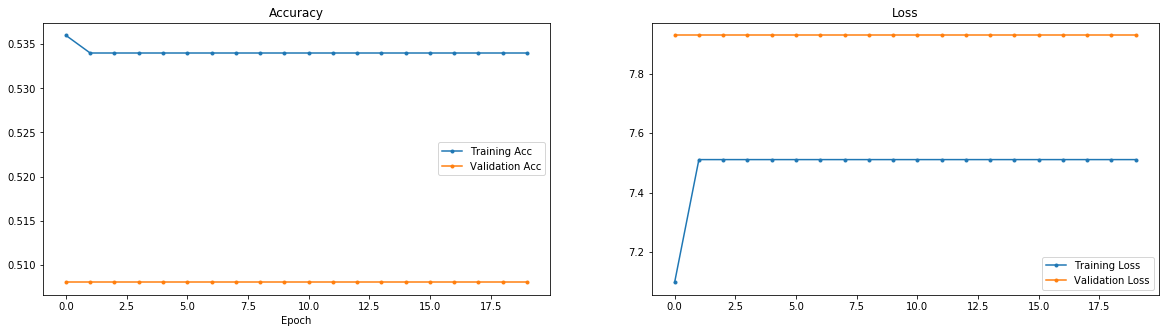

In [36]:
# Get the training history 
history = model.history 

# Accuracy and loss for test set
acc = history.history['acc']
loss = history.history['loss']

# Accuracy and loss for validation set
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

# Accuracy
plt.figure(figsize= (20,5))
plt.subplot(1,2,1)
plt.plot(acc, label='Training Acc', marker='.')
plt.plot(val_acc, label='Validation Acc', marker='.')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss', marker='.')
plt.plot(val_loss, label='Validation Loss', marker='.')
plt.title('Loss')
plt.legend()
plt.show()

We want to see how accuracy improves and how loss decreases. But in this model, they stay pretty constant.
Seeing how the results are not great, let's build another model. 

## 2. Build the model according to the paper

The authors mention how they build their CNN to get a good accuracy. While we are not using PCam, we can still aim for ~80% accuracy of the test. 

Let's build the model according to the one here by [Geert Litjens](https://geertlitjens.nl/post/getting-started-with-camelyon/)

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD


In [38]:
#First setup the input to the network to 96 x 96
input_img = Input(shape=(96,96,3))

# Define the layers of the convolutional network
# Three blocks of two convolutional layers 
# A max-pool layer.

# Filter size 16
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Filter size 32
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Filter size 64
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)


# Add the Flatten layer from 4D to 2D 
#The conv2d layer extracts and learn the spatial features
# this is then passed to a dense layer
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
# Add Dropout for regularization

x = Dropout(rate=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
# As activation use Softmax to determine 'tumor' or 'non-tumor'
predictions = Dense(2, activation='softmax')(x)

# Set the input and outputs of the model
model2 = Model(inputs=input_img, outputs=predictions)
# Optimize using SGD
sgd_opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
model2.compile(optimizer=sgd_opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 94, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0         
__________

# Size down the Data
This time let's take a 16th of the data

In [39]:
#select a small chunk of train data
small_X_train = X_train[0:16384]
small_y_train = y_train[0:16384]
small_X_train.shape

(16384, 96, 96, 3)

In [40]:
X_test.shape

(32768, 96, 96, 3)

In [41]:
#select a small chunk of test data
small_X_test = X_test[0:2048]
small_y_test = y_test[0:2048]
small_X_test.shape

(2048, 96, 96, 3)

In [42]:
#select a small chunk of train data
small_X_val = X_val[0:2048]
small_y_val = y_val[0:2048]
small_X_val.shape

(2048, 96, 96, 3)

Reshape the data.

In [43]:
#reshape data
y_train_reshape = small_y_train.reshape(16384)
y_val_reshape = small_y_val.reshape(2048)

Fit the model.

In [44]:
fitting_model2 = model2.fit(small_X_train, y_train_reshape, batch_size= 1000, epochs = 4, verbose = 2, validation_data=(small_X_val,y_val_reshape))
# use batch size 4096 with step 5 

Train on 16384 samples, validate on 2048 samples
Epoch 1/4
 - 555s - loss: 8.0642 - acc: 0.4981 - val_loss: 8.4447 - val_acc: 0.4761
Epoch 2/4
 - 495s - loss: 8.0817 - acc: 0.4986 - val_loss: 8.4447 - val_acc: 0.4761
Epoch 3/4
 - 503s - loss: 8.0817 - acc: 0.4986 - val_loss: 8.4447 - val_acc: 0.4761
Epoch 4/4
 - 515s - loss: 8.0817 - acc: 0.4986 - val_loss: 8.4447 - val_acc: 0.4761


Using the notebook from morning challenge, learn how to plot accuracy and loss over time.

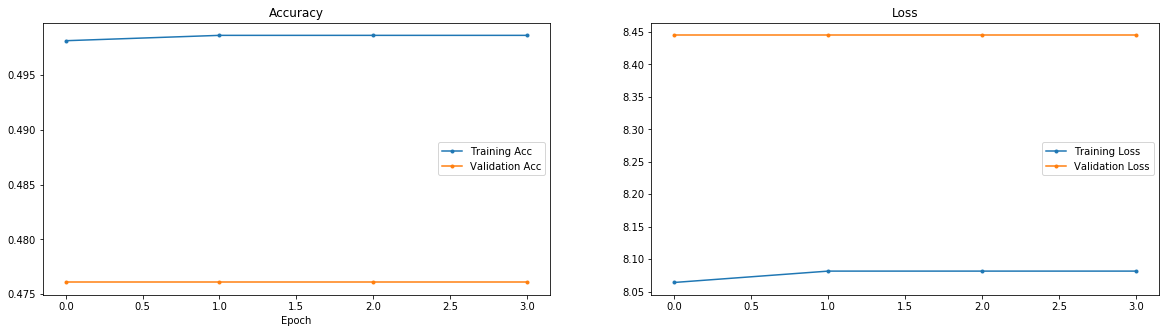

In [45]:
# Get the training history 
history = model2.history 

# Accuracy and loss for test set
acc = history.history['acc']
loss = history.history['loss']

# Accuracy and loss for validation set
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

# Accuracy
plt.figure(figsize= (20,5))
plt.subplot(1,2,1)
plt.plot(acc, label='Training Acc', marker='.')
plt.plot(val_acc, label='Validation Acc', marker='.')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss', marker='.')
plt.plot(val_loss, label='Validation Loss', marker='.')
plt.title('Loss')
plt.legend()
plt.show()

Sadly, the results are not great. The accuracy drops instead of increasing. But let's see if running with a different batch size and number of epochs will make a difference.

## Use different epoch and batch size

In [46]:
fitting_model2 = model2.fit(small_X_train, y_train_reshape, batch_size= 500, epochs = 10, verbose = 2, validation_data=(small_X_val,y_val_reshape))
# use batch size 4096 with step 5 

Train on 16384 samples, validate on 2048 samples
Epoch 1/10
 - 282s - loss: 8.0817 - acc: 0.4986 - val_loss: 8.4447 - val_acc: 0.4761
Epoch 2/10
 - 258s - loss: 8.0817 - acc: 0.4986 - val_loss: 8.4447 - val_acc: 0.4761
Epoch 3/10
 - 255s - loss: 8.0817 - acc: 0.4986 - val_loss: 8.4447 - val_acc: 0.4761
Epoch 4/10
 - 254s - loss: 8.0817 - acc: 0.4986 - val_loss: 8.4447 - val_acc: 0.4761
Epoch 5/10
 - 255s - loss: 8.0817 - acc: 0.4986 - val_loss: 8.4447 - val_acc: 0.4761
Epoch 6/10
 - 254s - loss: 8.0817 - acc: 0.4986 - val_loss: 8.4447 - val_acc: 0.4761
Epoch 7/10
 - 255s - loss: 8.0817 - acc: 0.4986 - val_loss: 8.4447 - val_acc: 0.4761
Epoch 8/10
 - 256s - loss: 8.0817 - acc: 0.4986 - val_loss: 8.4447 - val_acc: 0.4761
Epoch 9/10
 - 251s - loss: 8.0817 - acc: 0.4986 - val_loss: 8.4447 - val_acc: 0.4761
Epoch 10/10
 - 254s - loss: 8.0817 - acc: 0.4986 - val_loss: 8.4447 - val_acc: 0.4761


Let's plot the results and visualize the accuracy and loss.

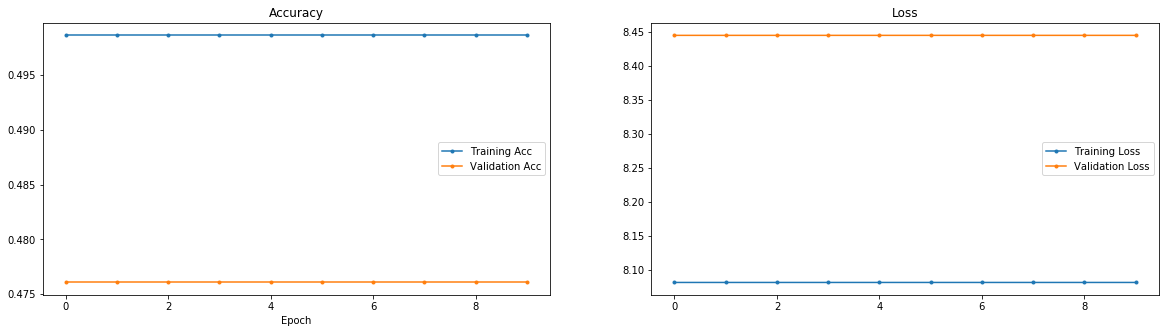

In [47]:
# Get the training history 
history = model2.history 

# Accuracy and loss for test set
acc = history.history['acc']
loss = history.history['loss']

# Accuracy and loss for validation set
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

# Accuracy
plt.figure(figsize= (20,5))
plt.subplot(1,2,1)
plt.plot(acc, label='Training Acc', marker='.')
plt.plot(val_acc, label='Validation Acc', marker='.')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss', marker='.')
plt.plot(val_loss, label='Validation Loss', marker='.')
plt.title('Loss')
plt.legend()
plt.show()

Sadly, the model did not improve at all. We will have to try another model. For this time, we will read the files from the `tensorflow_datasets`. We will use the tutorial mentioned above by [Geert Litjens](https://geertlitjens.nl/post/getting-started-with-camelyon/) and follow it throughly (not just the model).

# 3. Model of CNN with accurate prediction 

In [48]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# Import warning to remove all the extra warnings
import warnings
warnings.filterwarnings('ignore')

## Load the Data

Install `tensorflow_datasets` in the environment. 
Load the data from he tensorflow_datasets. This is a more direct route in getting the files. Plus it doesn't have a HDF5Matrix value (similar to numpys)

In [49]:
import tensorflow_datasets as tfds
pcam, pcam_info = tfds.load("patch_camelyon", with_info=True)
print(pcam_info)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



W0901 22:35:56.457463 53576 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=0.1.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.
',
    urls=['https://patchcamelyon.grand-challenge.org/'],
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_2

Let's see what type of data is `pcam` stored as.

In [50]:
# check the type for pcam
type(pcam)

dict

In [51]:
# check the type for pcam_info
type(pcam_info)

tensorflow_datasets.core.dataset_info.DatasetInfo

In [52]:
#see the pcam key names.
print("First key",list(pcam.keys())[0])
print("Second key",list(pcam.keys())[1])
print("Third key",list(pcam.keys())[2])

First key test
Second key train
Third key validation


## Set up the model.

In [54]:
# Set up the input shape of the images which is 96x96 pixels with 3 channels
input_img = Input(shape=(96,96,3))

# Define the Convolutional Neural network layers
# Define three blocks: each containing 2 convolutional layers and one max-pool layer
# size 16
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# size 32
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# size 64
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Flatten the layer from 4D to 2D -- need this to add the dense layers at the end.
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# Add Dropout for regularization. 
x = Dropout(rate=0.2)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)

# Add a softmax layer in the  last dense layer -- with predict one of the two outcomes: tumors or non-tumors.
predictions = Dense(2, activation='softmax')(x)

# Define inputs the images
# and output the predictions 
model3 = Model(inputs=input_img, outputs=predictions)

# Will use the Stochastic Gradient Descent
# with Nesterov Momentum.
sgd_opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)

#for loss we'll use categorical_crossentropy
model3.compile(optimizer=sgd_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])  #save the accuracy as a metrics

# See the Model Summary
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 94, 94, 16)        448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 92, 92, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 44, 44, 32)        4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 21, 21, 32)        0         
__________

Next, we need to define function that will convert the images that are stores in the dictionary into float32. Up until now, they are stored as int8 patches.

In [55]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

Define a `tf.data` pipeline that will convert the images. Using a `shuffle` we will pick random $1024$ samples.
For training we'll use batches of $64$ and for validation batches of $128$. Add a `prefetch` to be able to prefetch two of those batches.

The `map` function is much better than replace as we are dealing with a large data size. More details [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) 

In [56]:
# the map function is much better than replace as we are dealing with a large data size.
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

## Fit the model

Fit the model on the train pipeline, validated it on the validation pipeline, set the number of epochs to 5, with a step of 4096. Those numbers cover all the training and validation datasets.

In [57]:
hist = model3.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=2, epochs=5, steps_per_epoch=4096, validation_steps=256)

Epoch 1/5
 - 4121s - loss: 0.4490 - acc: 0.7790 - val_loss: 0.3638 - val_acc: 0.8327
Epoch 2/5
 - 4144s - loss: 0.3080 - acc: 0.8717 - val_loss: 0.3974 - val_acc: 0.8242
Epoch 3/5
 - 4140s - loss: 0.2628 - acc: 0.8928 - val_loss: 0.3335 - val_acc: 0.8537
Epoch 4/5
 - 4145s - loss: 0.2300 - acc: 0.9090 - val_loss: 0.5496 - val_acc: 0.7832
Epoch 5/5
 - 4141s - loss: 0.2097 - acc: 0.9181 - val_loss: 0.3103 - val_acc: 0.8665


## Test Accuracy

Create the test pipeline. Then check the test accuracy.

In [59]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model3.evaluate(test_pipeline, steps=128, verbose=0)[1]))

Test set accuracy is 0.8300


Great! The test accuracy is >80% as desired. This model has turned out to be better than the previous ones.

## Save the model

In [60]:
model3.save("./patchcamelyon.hf5")

## Visualize Loss and Accuracy

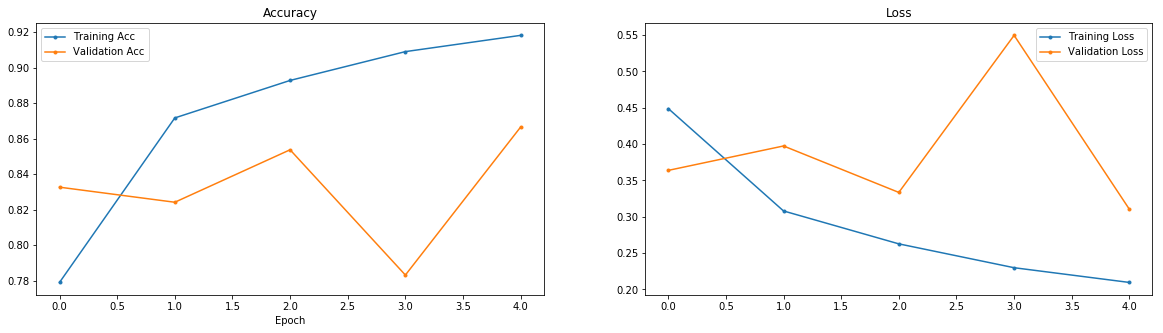

In [61]:
# Get the training history 
history = model3.history 

# Accuracy and loss for test set
acc = history.history['acc']
loss = history.history['loss']

# Accuracy and loss for validation set
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

# Accuracy
plt.figure(figsize= (20,5))
plt.subplot(1,2,1)
plt.plot(acc, label='Training Acc', marker='.')
plt.plot(val_acc, label='Validation Acc', marker='.')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss', marker='.')
plt.plot(val_loss, label='Validation Loss', marker='.')
plt.title('Loss')
plt.legend()
plt.show()

This model has turned out great. The accuracy improves over the time whereas the loss decreases. 

# Conclusion:


The first model we build had lacked in terms of layers. In the second model, even though we increased the number of layers and made it exactly as in model 3, the accuracy was still not great and barely improved from the first model (`model1`).

In this project we learnt how to use `tensorflow_datasets` and how fine tuning a model will eventually lead to a better model.
We learnt how to build a CNN model from scratch and also apply pre-existing models to cancer image classification. 